# Periodogram Fingerprinting 🫆
**Goal:** The smallest vector that allows to have a good compressed representation of a time-series.

How good is good? -> _uniqueness_ that allows distinguishing from different time-series.

Our fingerprint in this case is going to be composed of the following elements:
- **Metadata**: coordinates
- **Seasonality**: $P_{norm}^1$, $period^1$, $Dominance$, num_peaks
- **Time awareness**: $t_0, t_{max}$

The fingerprint is a vector of size $6+2k_{peaks}$

## Load data

In [21]:
import pickle
with open(f"../../data/1140_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
data_obs = data['data']
meta_obs = data['meta']

In [22]:
# Splits data
# Identifiers
with open("../../data/piezo_multiple_bro_id.pkl", "rb") as f:
    piezo_multiple_bro_id = pickle.load(f)
# Data
with open("../../data/1233_sample_migrated_GLD_split.pkl", "rb") as f:
    splits_dataset = pickle.load(f)
splits_data = splits_dataset['data']
splits_meta = splits_dataset['meta']

## Periodogram helper functions

In [23]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle, find_peaks
from scipy.spatial.distance import cosine
from sklearn.neighbors import NearestNeighbors

In [24]:
def compute_ls(t, y, freq_min, freq_max, n_freqs):
    """Compute Lomb–Scargle periodogram"""
    t = (np.asarray(t) - np.nanmin(t)) / 1000 / 86400 # Shift time so it starts at 0, convert to days.
    y = np.asarray(y) - np.nanmean(y)
    if len(t) < 5: return np.array([]), np.array([])
    freqs = np.linspace(freq_min, freq_max, n_freqs)
    p = lombscargle(t, y, 2 * np.pi * freqs)
    return freqs, p

In [25]:
def compute_ls_vector(freqs: np.ndarray, pgram: np.ndarray, k_peaks: int = 1, peak_height_frac: float = 0.1) -> np.ndarray:
    if pgram.size == 0 or freqs.size == 0:
        raise ValueError("Empty periodogram or frequency array")
        
    peaks, _ = find_peaks(pgram, height=pgram.max() * peak_height_frac)
    if peaks.size == 0:
        raise ValueError("No peaks found")
    
    # Normalization
    pk_powers = pgram[peaks] / np.sum(pgram)
    pk_periods = 1 / freqs[peaks]
    
    # Sort by power descending
    order = np.argsort(pk_powers)[::-1]
    pk_powers = pk_powers[order]
    pk_periods = pk_periods[order]
    
    # Top-k (pad with NaN if needed)
    k = min(k_peaks, pk_powers.size)
    powers_k = np.pad(pk_powers[:k], (0, k_peaks - k), constant_values=np.nan)
    periods_k = np.pad(pk_periods[:k], (0, k_peaks - k), constant_values=np.nan)

    # Dominance: Power max / sum of top-5
    top5 = pk_powers[:min(5, pk_powers.size)]
    dominance = pk_powers[0] / (top5.sum() + 1e-12)
    
    return np.concatenate([powers_k, periods_k, [dominance, peaks.size]])

In [26]:
def get_fingerprints(data, meta, freq_min, freq_max, n_freqs, k_peaks=1):
    fingerprint_dino, fingerprint_bro = {}, {}
    for gld in data.keys():
        dino_ts = data[gld]['dino']
        bro_ts = data[gld]['bro']
        try:
            freqs, pgram = compute_ls(dino_ts[:, 0], dino_ts[:, 1], freq_min=freq_min, freq_max=freq_max, n_freqs=n_freqs)
            ls_vector_dino = compute_ls_vector(freqs, pgram, k_peaks=k_peaks)
            freqs, pgram = compute_ls(bro_ts[:, 0], bro_ts[:, 1], freq_min=freq_min, freq_max=freq_max, n_freqs=n_freqs)
            ls_vector_bro = compute_ls_vector(freqs, pgram, k_peaks=k_peaks)
        except ValueError as e:
            print(f"Skipping {gld}: {e}")
            continue
        coords_dino = [meta[gld]['x_dino'], meta[gld]['y_dino']]
        coords_bro = [meta[gld]['x_bro'], meta[gld]['y_bro']]
        # time_vector_dino = [dino_ts[0, 0]/ 1000 / 86400, np.max(dino_ts[:, 0])/ 1000 / 86400]
        # time_vector_bro = [bro_ts[0, 0]/ 1000 / 86400, np.max(bro_ts[:, 0])/ 1000 / 86400]
        # concatenate all features
        fingerprint_dino[gld] = np.concatenate([coords_dino, ls_vector_dino])
        fingerprint_bro[gld] = np.concatenate([coords_bro, ls_vector_bro])
    return fingerprint_dino, fingerprint_bro

In [27]:
def calc_precision_k(cmp, k):
    cmp_k = np.sum(cmp[:, :k], axis=1) / k
    mean_cmp_k = np.mean(cmp_k)
    return mean_cmp_k, cmp_k

## Fingerprint on test-dataset

In [11]:
# Lomb-scargle periodogram params
freq_min = 0.7 / 365  # cycles per day
freq_max = 2 / 365    # cycles per day
n_freqs = 1000
k_peaks = 1  # number of peaks info to include in the fingerprint

fingerprint_dino, fingerprint_bro = get_fingerprints(data_obs, meta_obs, freq_min, freq_max, n_freqs, k_peaks)

In [29]:
print(f"Number of fingerprints: {len(fingerprint_dino)} ({len(fingerprint_dino)/len(data_obs)*100:.1f}%)")
print(f"Number of features in fingerprint: {len(next(iter(fingerprint_dino.values())))}")

Number of fingerprints: 1129 (99.0%)
Number of features in fingerprint: 6


### Statistics

In [10]:
eucl_dist_match, cos_dist_match = [], []
for gld in data_obs.keys():
    if gld not in fingerprint_dino or gld not in fingerprint_bro:
        print(f"Skipping {gld} for statistics: missing fingerprint")
        continue
    dino_fp = fingerprint_dino[gld]
    bro_fp = fingerprint_bro[gld]
    eucl_dist_match.append(np.linalg.norm(dino_fp - bro_fp))
    cos_dist_match.append(cosine(dino_fp, bro_fp))

Skipping GLD000000135161 for statistics: missing fingerprint
Skipping GLD000000078265 for statistics: missing fingerprint
Skipping GLD000000055760 for statistics: missing fingerprint
Skipping GLD000000061186 for statistics: missing fingerprint
Skipping GLD000000080587 for statistics: missing fingerprint
Skipping GLD000000078591 for statistics: missing fingerprint
Skipping GLD000000080869 for statistics: missing fingerprint
Skipping GLD000000061724 for statistics: missing fingerprint
Skipping GLD000000110132 for statistics: missing fingerprint
Skipping GLD000000056931 for statistics: missing fingerprint
Skipping GLD000000068618 for statistics: missing fingerprint


Statistics of norm distances between periodogram fingerprints of matching bro and dino pairs:
Mean: 0.6409075859488976 ± Std: 0.1957815276228149
Median: 0.7071067811865476
Max: 2.415419277378387, Min: 0.0

Statistics of Cosine distances between periodogram fingerprints of matching bro and dino pairs:
Mean: 8.271299205045944e-13 ± Std: 5.218092812003245e-13
Median: 7.637224186396452e-13
Max: 1.2897793943977831e-11, Min: 0.0


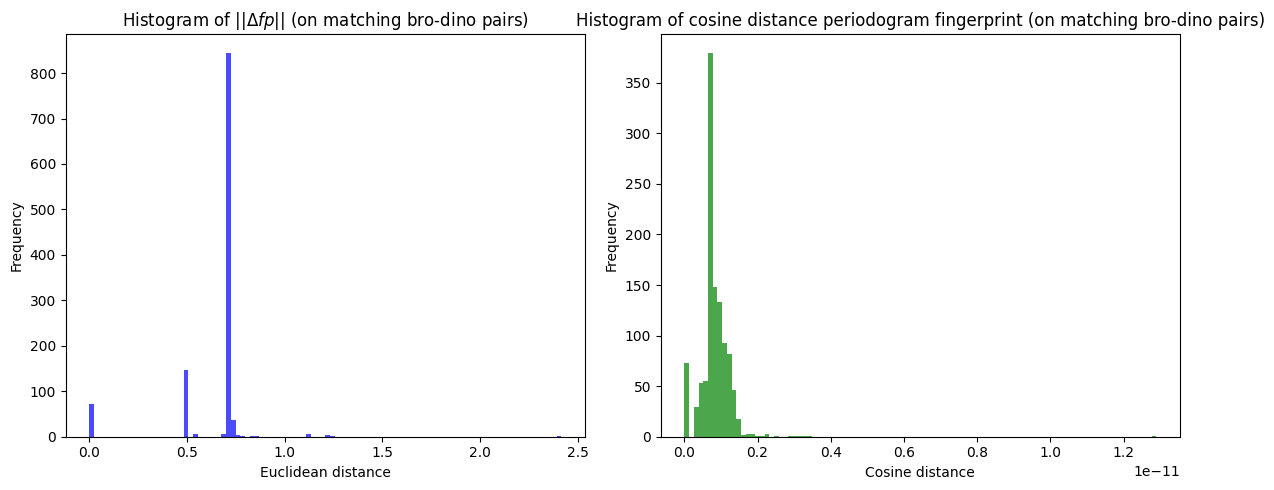

In [11]:
# Statistics: matching DINO-BRO pairs
print(f"Statistics of norm distances between periodogram fingerprints of matching bro and dino pairs:")
print(f"Mean: {np.mean(eucl_dist_match)} ± Std: {np.std(eucl_dist_match)}")
print(f"Median: {np.median(eucl_dist_match)}")
print(f"Max: {np.max(eucl_dist_match)}, Min: {np.min(eucl_dist_match)}")

print(f"\nStatistics of Cosine distances between periodogram fingerprints of matching bro and dino pairs:")
print(f"Mean: {np.mean(cos_dist_match)} ± Std: {np.std(cos_dist_match)}")
print(f"Median: {np.median(cos_dist_match)}")
print(f"Max: {np.max(cos_dist_match)}, Min: {np.min(cos_dist_match)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axes[0].hist(eucl_dist_match, bins=100, color='blue', alpha=0.7)
axes[0].set_xlabel("Euclidean distance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of $||\\Delta fp||$ (on matching bro-dino pairs)")
axes[1].hist(cos_dist_match, bins=100, color='green', alpha=0.7)
axes[1].set_xlabel("Cosine distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of cosine distance periodogram fingerprint (on matching bro-dino pairs)")

plt.tight_layout()
plt.show()

In [12]:
cos_dist_nonmatching, eucl_dist_nonmatching, gld_pairs_nonmatching = [], [], []
max_pairs = 1000  # pick how many non-matching pairs you want
seen = set()
while len(seen) < max_pairs:
    g1, g2 = random.sample(list(data_obs.keys()), 2)  # ensures g1 != g2
    if (g1, g2) in seen: continue
    if g1 not in fingerprint_dino or g1 not in fingerprint_bro or g2 not in fingerprint_dino or g2 not in fingerprint_bro: continue
    dino_fp = fingerprint_dino[g1]
    bro_fp = fingerprint_bro[g2]
    # Compare the fingerprints (example: Euclidean distance)
    eucl_dist_nonmatching.append(np.linalg.norm(dino_fp - bro_fp))
    cos_dist_nonmatching.append(cosine(dino_fp, bro_fp))
    seen.add((g1, g2))

Statistics of norm distances between periodogram fingerprints of non-matching bro and dino pairs:
Mean: 109867.39890956225 ± Std: 60235.12263782934
Median: 107534.6382350137
Max: 282016.5951851892, Min: 3156.569306048548

Statistics of Cosine distances between periodogram fingerprints of non-matching bro and dino pairs:
Mean: 0.013240177983498608 ± Std: 0.016049760862934206
Median: 0.006678590061885925
Max: 0.09495380364145423, Min: 4.232749926447177e-06


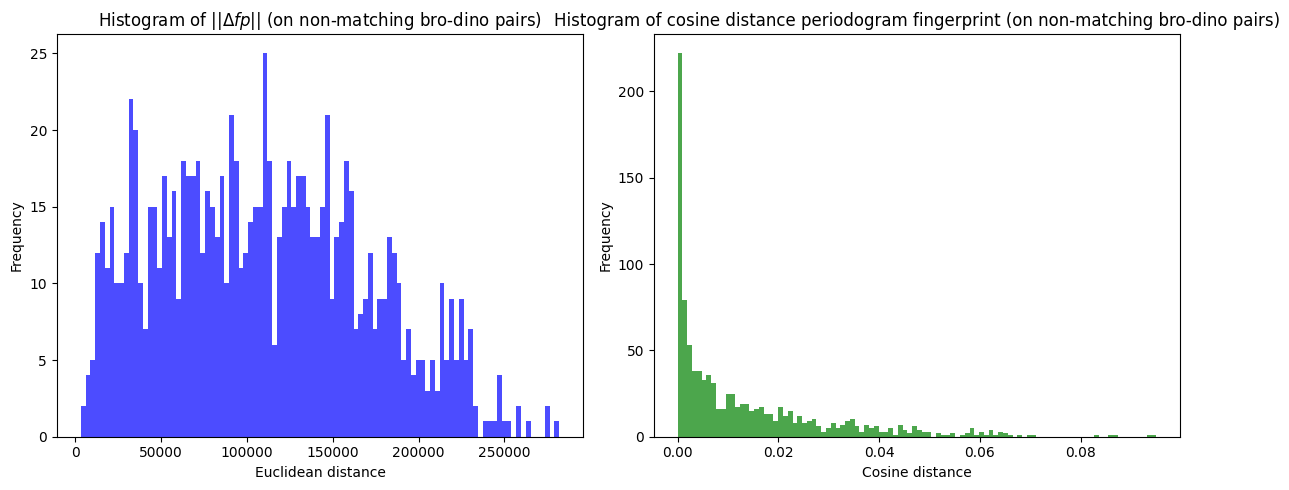

In [13]:
# Statistics: non-matching DINO-BRO pairs
print(f"Statistics of norm distances between periodogram fingerprints of non-matching bro and dino pairs:")
print(f"Mean: {np.mean(eucl_dist_nonmatching)} ± Std: {np.std(eucl_dist_nonmatching)}")
print(f"Median: {np.median(eucl_dist_nonmatching)}")
print(f"Max: {np.max(eucl_dist_nonmatching)}, Min: {np.min(eucl_dist_nonmatching)}")
print(f"\nStatistics of Cosine distances between periodogram fingerprints of non-matching bro and dino pairs:")
print(f"Mean: {np.mean(cos_dist_nonmatching)} ± Std: {np.std(cos_dist_nonmatching)}")
print(f"Median: {np.median(cos_dist_nonmatching)}")
print(f"Max: {np.max(cos_dist_nonmatching)}, Min: {np.min(cos_dist_nonmatching)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axes[0].hist(eucl_dist_nonmatching, bins=100, color='blue', alpha=0.7)
axes[0].set_xlabel("Euclidean distance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of $||\\Delta fp||$ (on non-matching bro-dino pairs)")
axes[1].hist(cos_dist_nonmatching, bins=100, color='green', alpha=0.7)
axes[1].set_xlabel("Cosine distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of cosine distance periodogram fingerprint (on non-matching bro-dino pairs)")

plt.tight_layout()
plt.show()

### Search 🔍
Now that we have fingerprints, we want to search in the database to see which kind of matches do we find.

In [12]:
nn = NearestNeighbors(metric="l1")
nn.fit(np.array(list(fingerprint_dino.values())))

NearestNeighbors(metric='l1')

In [13]:
# evaluation: find nearest neighbors (trained on DINO data) to BRO fingerprints
k = 3
dists, indices = nn.kneighbors(np.stack(list(fingerprint_bro.values())), n_neighbors=k)
label_test = np.array(list(fingerprint_bro.keys()))
retrieved_label = np.array([[list(fingerprint_bro.keys())[i] for i in neigh] for neigh in indices])
cmp = label_test[:, None] == retrieved_label

In [14]:
neigh_level = 1
prec_k, prec_each_k = calc_precision_k(cmp, k=neigh_level)
print(f"PREC@{neigh_level}={prec_k:.3f}")

PREC@1=0.946


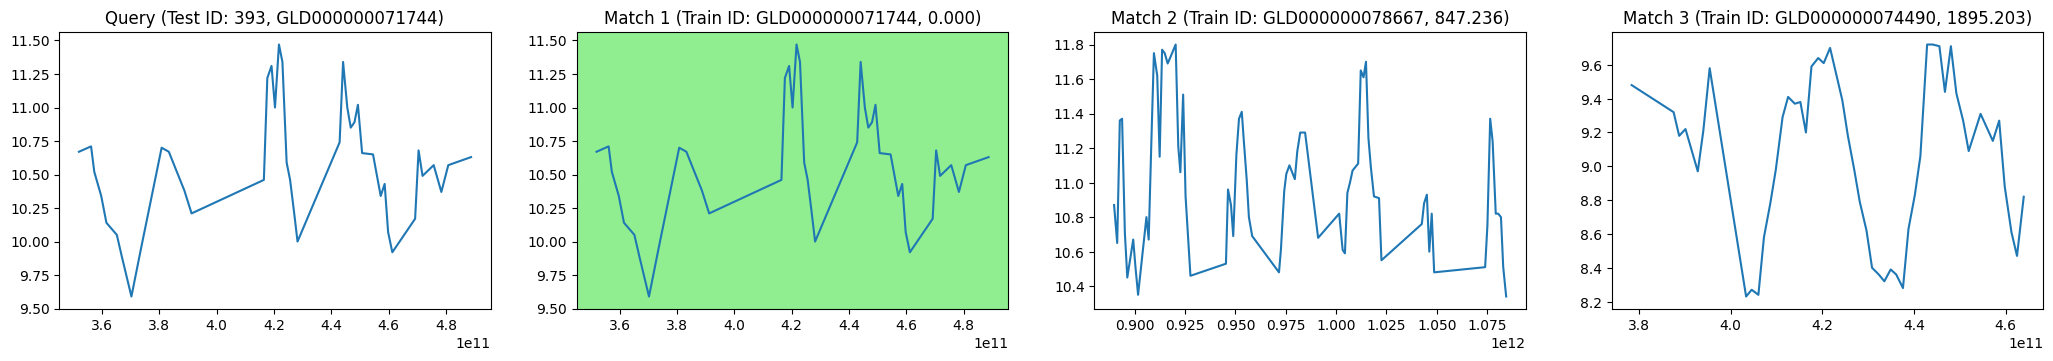

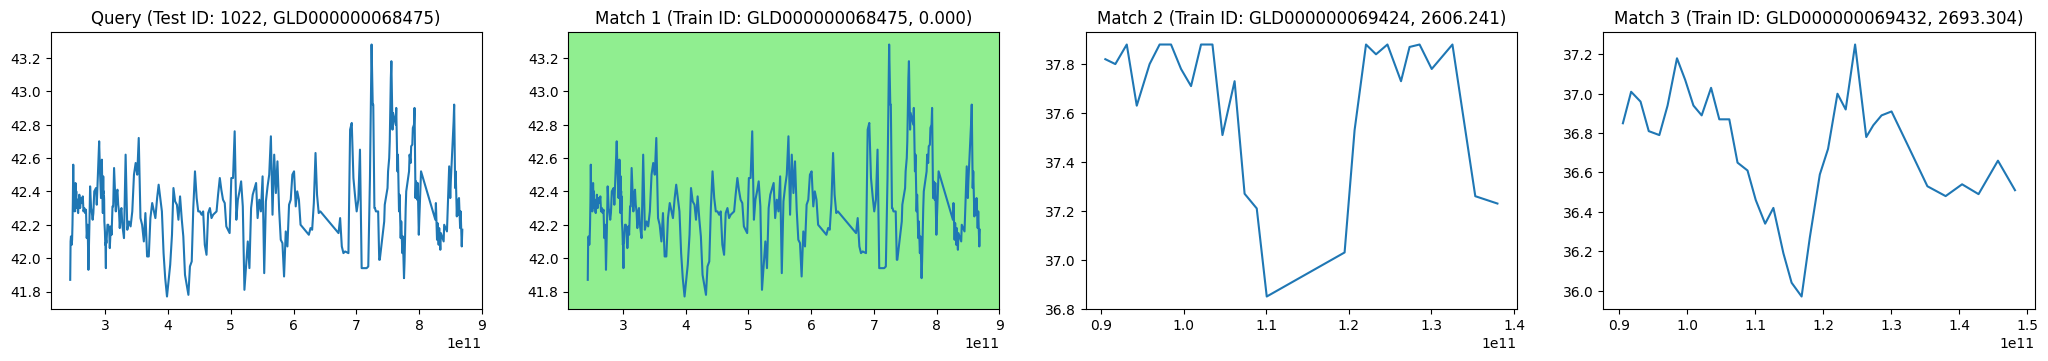

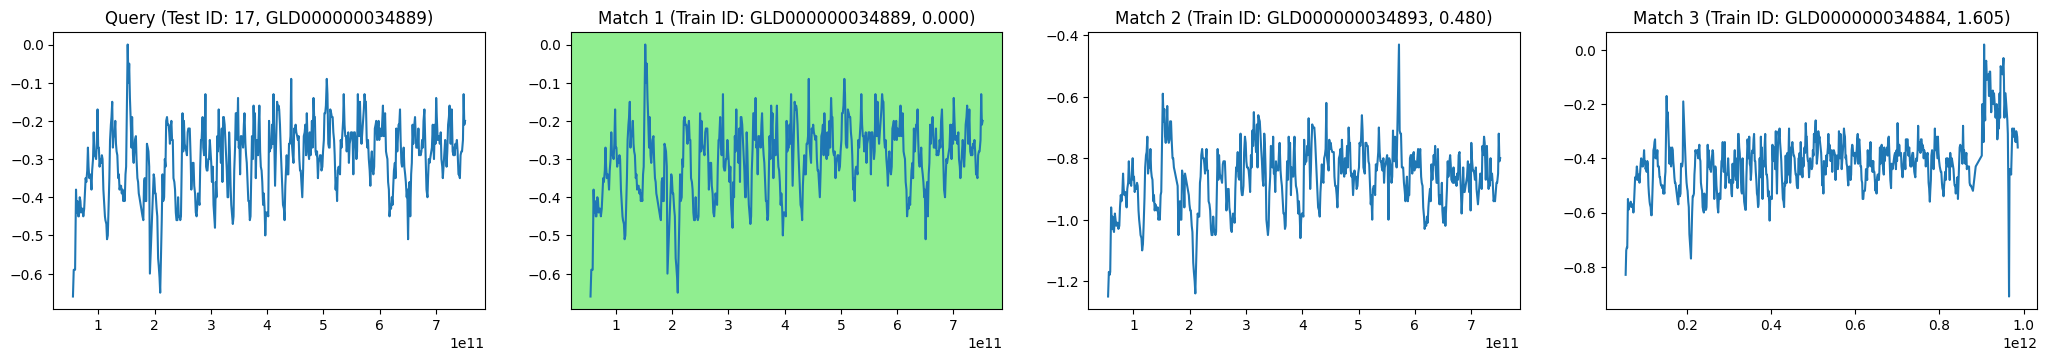

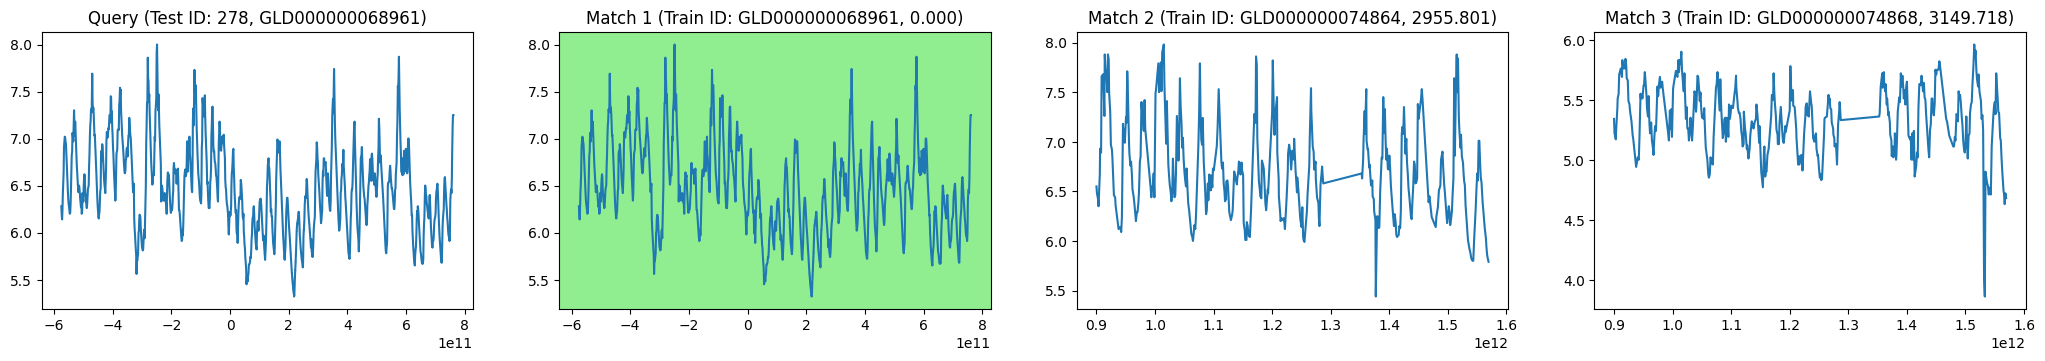

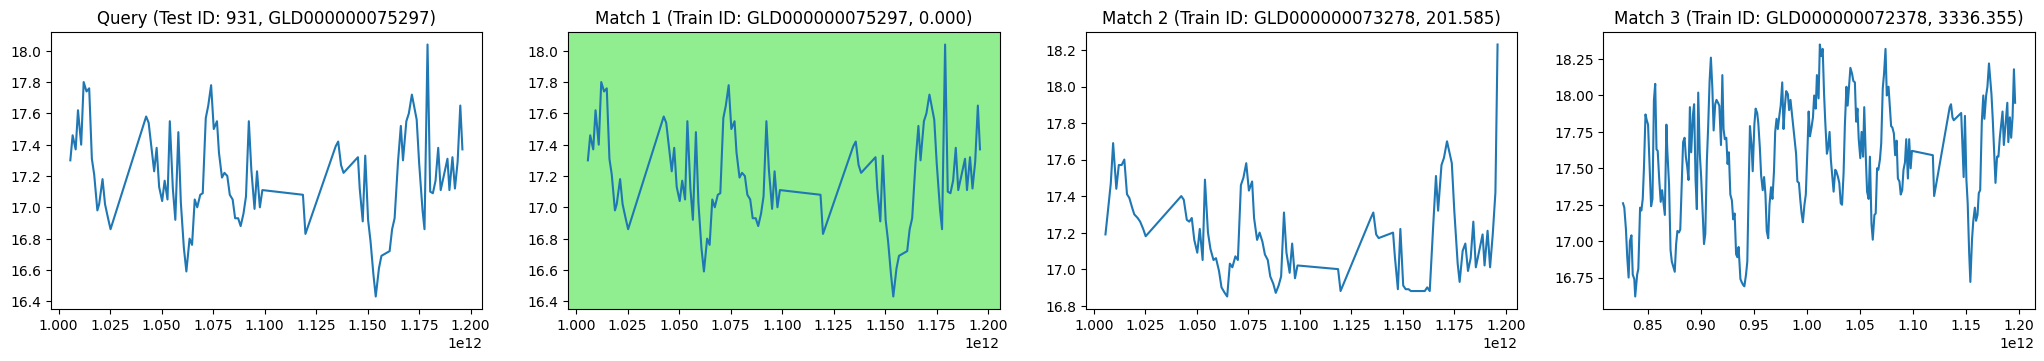

In [33]:
n_plots = 5
n_cols = 1 + k
selected_indices = np.random.choice(len(fingerprint_dino.keys()), size=n_plots, replace=False)
    
# plotting loop: one query + top-k matches per selected sample
for i in selected_indices:
    gld = list(fingerprint_bro.keys())[i]
    neighs = indices[i][:k]
    distances = dists[i][:k]
    label = label_test[i]
    neigh_labels = retrieved_label[i]
    
    fig, ax = plt.subplots(1, n_cols, figsize=(6.4 * n_cols, 3.6))
    # query (BRO, unseen)
    ax[0].plot(data_obs[gld]["bro"][:,0], data_obs[gld]["bro"][:,1])
    ax[0].set_title(f"Query (Test ID: {i}, {gld})")
    # predictions (DINO, seen)
    for j, (n_idx, n_label, dist) in enumerate(zip(neighs, neigh_labels, distances), start=1):
        ax[j].plot(data_obs[n_label]["dino"][:,0], data_obs[n_label]["dino"][:,1])
        ax[j].set_title(f"Match {j} (Train ID: {n_label}, {dist:.3f})")
        if label == n_label: ax[j].set_facecolor("lightgreen")

## Fingerprint on split dataset: more difficult cases
We would like to see what are the distances between fingerprints of time-series that are:
- Partially the same: split data 1-to-many
- Have small changes (QC)

In [16]:
# Lomb-scargle periodogram params
freq_min = 0.7 / 365  # cycles per day
freq_max = 2 / 365    # cycles per day
n_freqs = 1000
k_peaks = 1          # number of peaks info to include in the fingerprint

fp_split_dino, fp_split_bro = get_fingerprints(splits_data, splits_meta, freq_min, freq_max, n_freqs, k_peaks)

In [35]:
print(f"Number of dino fingerprints: {len(fp_split_dino)} ({len(fp_split_dino)/len(splits_meta)*100:.1f}%)")
print(f"Number of bro fingerprints: {len(fp_split_bro)} ({len(fp_split_bro)/len(splits_meta)*100:.1f}%)")

Number of dino fingerprints: 1164 (94.4%)
Number of bro fingerprints: 1164 (94.4%)


### Distance analysis

In [21]:
# On partial matches (100% certainty that the BRO series is a subset of the DINO series)
eucl_dist_match_split, cos_dist_match_split = [], []
for gld in fp_split_dino.keys():
    if gld not in fp_split_bro: continue
    dino_fp = fp_split_dino[gld]
    bro_fp = fp_split_bro[gld]
    eucl_dist_match_split.append(np.linalg.norm(dino_fp - bro_fp))
    cos_dist_match_split.append(cosine(dino_fp, bro_fp))

Statistics of norm distances between periodogram fingerprints of matching bro and dino pairs:
Mean: 7046.920149536856 ± Std: 3581.697842312444
Median: 6696.480293465491
Max: 18938.684235532244, Min: 548.5019801759657

Statistics of Cosine distances between periodogram fingerprints of matching bro and dino pairs:
Mean: 0.00012496394152943725 ± Std: 0.00012866716409408742
Median: 8.357307117029533e-05
Max: 0.0010672296864950859, Min: 6.123520087664147e-07


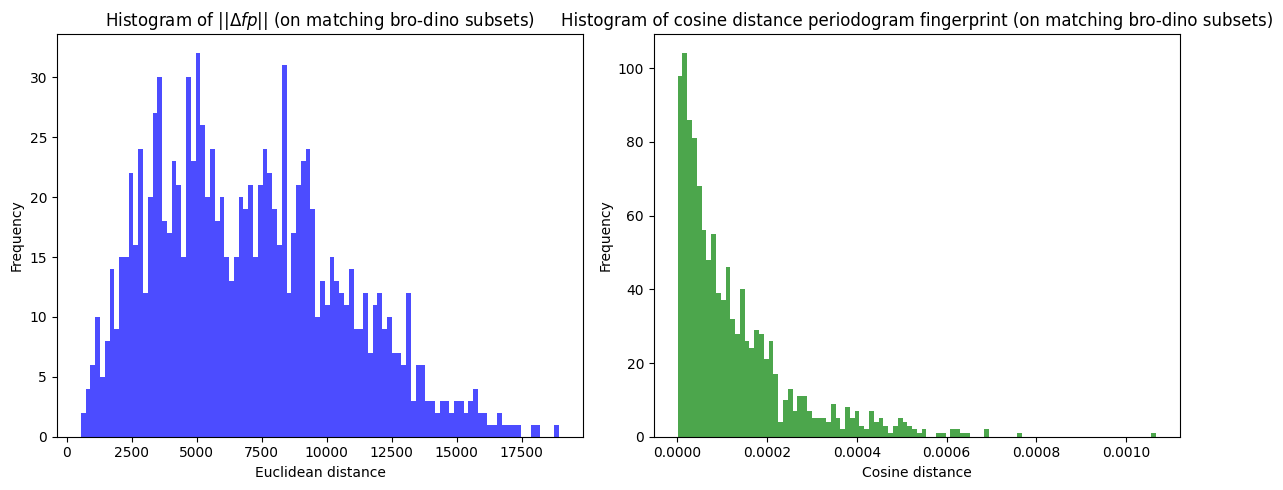

In [22]:
print(f"Statistics of norm distances between periodogram fingerprints of matching bro and dino pairs:")
print(f"Mean: {np.mean(eucl_dist_match_split)} ± Std: {np.std(eucl_dist_match_split)}")
print(f"Median: {np.median(eucl_dist_match_split)}")
print(f"Max: {np.max(eucl_dist_match_split)}, Min: {np.min(eucl_dist_match_split)}")

print(f"\nStatistics of Cosine distances between periodogram fingerprints of matching bro and dino pairs:")
print(f"Mean: {np.mean(cos_dist_match_split)} ± Std: {np.std(cos_dist_match_split)}")
print(f"Median: {np.median(cos_dist_match_split)}")
print(f"Max: {np.max(cos_dist_match_split)}, Min: {np.min(cos_dist_match_split)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axes[0].hist(eucl_dist_match_split, bins=100, color='blue', alpha=0.7)
axes[0].set_xlabel("Euclidean distance")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Histogram of $||\\Delta fp||$ (on matching bro-dino subsets)")
axes[1].hist(cos_dist_match_split, bins=100, color='green', alpha=0.7)
axes[1].set_xlabel("Cosine distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of cosine distance periodogram fingerprint (on matching bro-dino subsets)")

plt.tight_layout()
plt.show()

### Search
A couple of differences in the approach taken in this case are:
1. Because in the _split_ dataset we have for each DINO series multiple BRO series that should be a match, we are going to train the NearestNeighbours on the BRO data and evaluate (query) with the DINO data.
2. **Labels**: We used GLD as a labels before but in _split_ we have multiple DINO series with the same GLD. There can be matches that are correct but because of using GLD as label they might be flagged as incorrect.

In [28]:
nn_split = NearestNeighbors(metric="l1")
nn_split.fit(np.array(list(fp_split_bro.values())))

NearestNeighbors(metric='l1')

In [29]:
# evaluation: find nearest neighbors (trained on BRO data) to DINO fingerprints
k = 3
dists, indices = nn_split.kneighbors(np.stack(list(fp_split_dino.values())), n_neighbors=k)
#label_test = np.array(list(fp_split_dino.keys()))
label_test = []
for gld in fp_split_dino.keys():
    if gld in splits_data:
        piezo_dbk = splits_meta[gld].get('PIEZOMETER_DBK')
        label_test.append(str(piezo_dbk))

retrieved_label = [[label_test[i] for i in neigh] for neigh in indices]
cmp = np.array(label_test)[:, None] == np.array(retrieved_label)

In [30]:
prec_k, prec_each_k = calc_precision_k(cmp, k=1)
print(f"PREC@{1}={prec_k:.3f}")
prec_k, prec_each_k = calc_precision_k(cmp, k=3)
print(f"PREC@{3}={prec_k:.3f}")

PREC@1=0.973
PREC@3=0.972


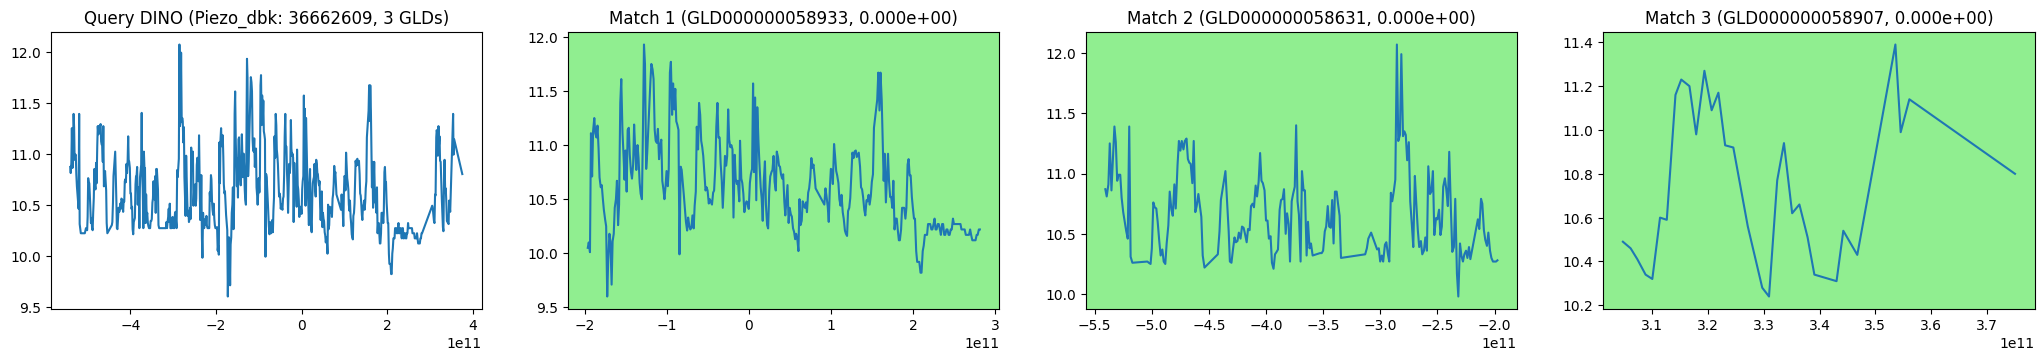

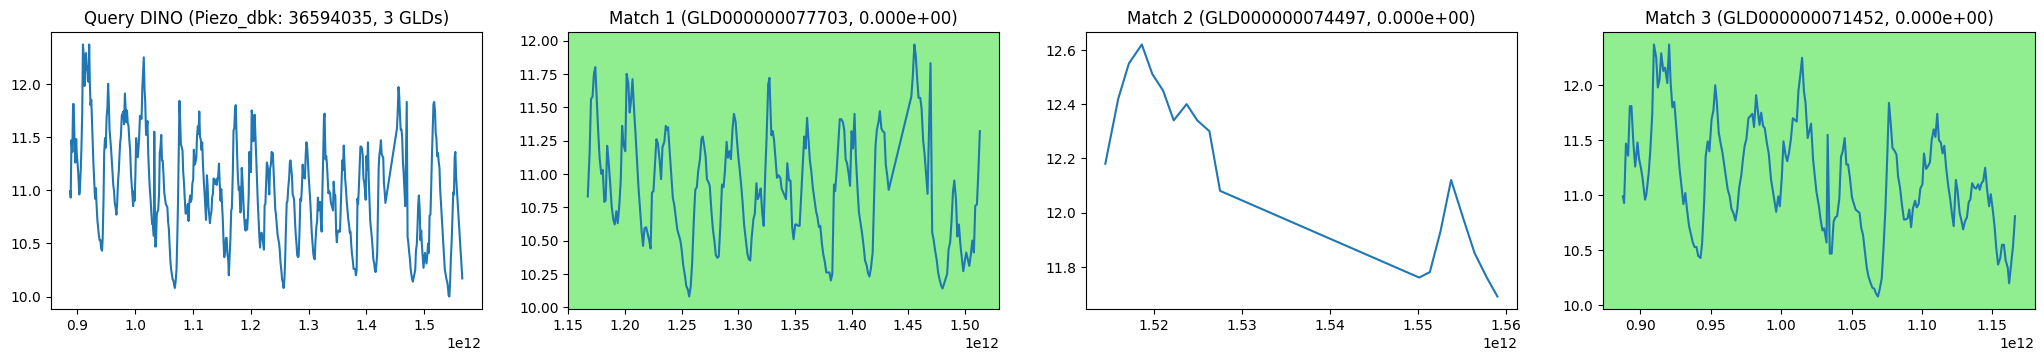

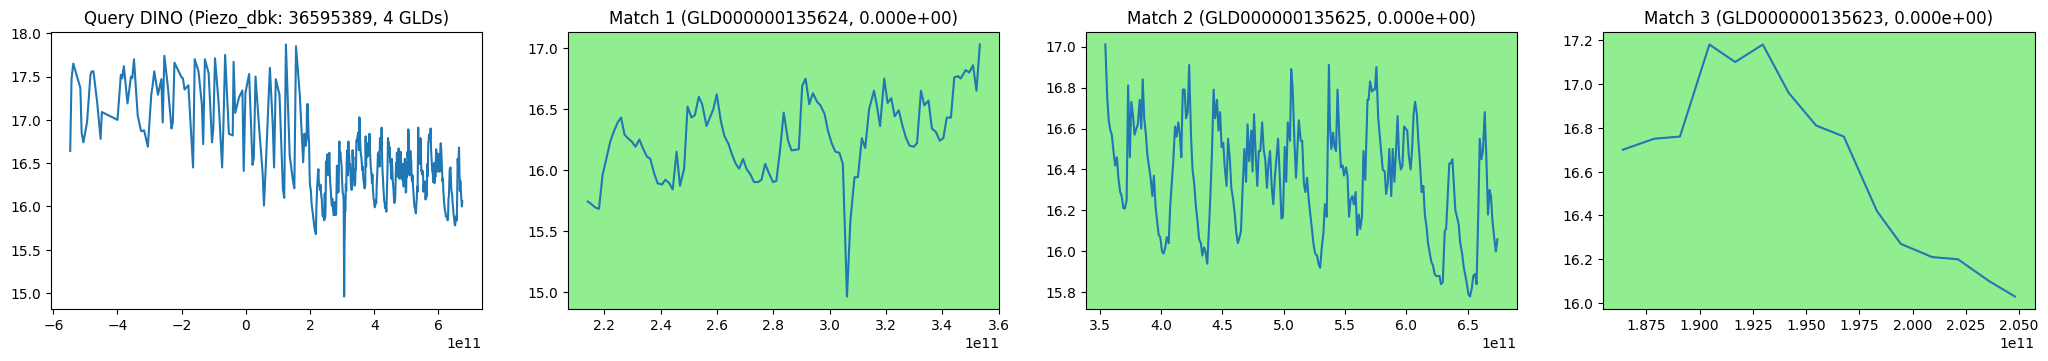

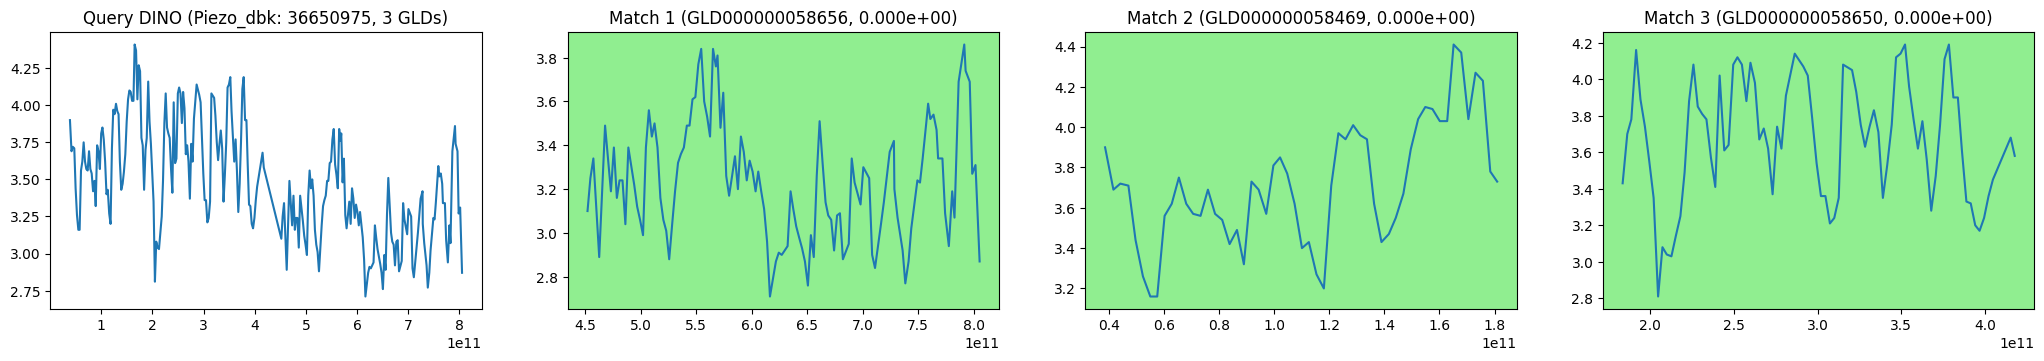

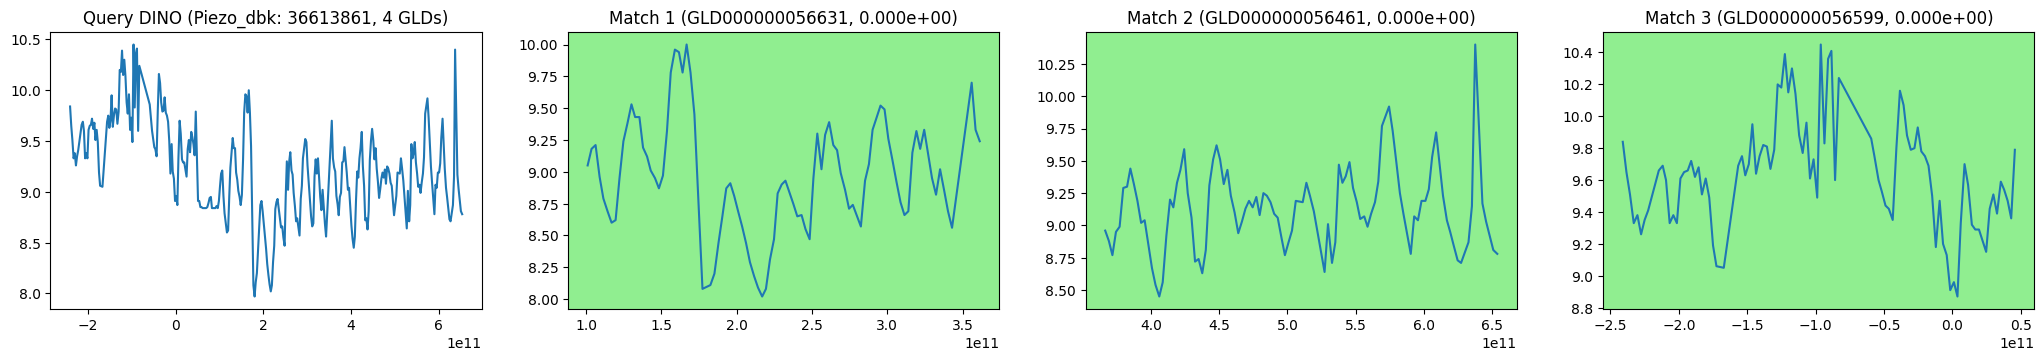

In [31]:
n_plots = 5
n_cols = 1 + k
selected_indices = np.random.choice(len(fp_split_bro.keys()), size=n_plots, replace=False)
    
# plotting loop: one query + top-k matches per selected sample
for i in selected_indices:
    gld = list(fp_split_bro.keys())[i]
    neighs = indices[i][:k]
    distances = dists[i][:k]
    label = label_test[i]
    neigh_labels = retrieved_label[i]
    n_gld_per_piezo_dbk = len(piezo_multiple_bro_id[int(label)])

    fig, ax = plt.subplots(1, n_cols, figsize=(6.4 * n_cols, 3.6))
    # query (DINO, unseen)
    ax[0].plot(splits_data[gld]["dino"][:,0], splits_data[gld]["dino"][:,1])
    ax[0].set_title(f"Query DINO (Piezo_dbk: {label}, {n_gld_per_piezo_dbk} GLDs)")
    # predictions (DINO, seen)
    for j, (n_idx, n_label, dist) in enumerate(zip(neighs, neigh_labels, distances), start=1):
        gld_j = list(fp_split_dino.keys())[n_idx]
        ax[j].plot(splits_data[gld_j]["bro"][:,0], splits_data[gld_j]["bro"][:,1])
        ax[j].set_title(f"Match {j} ({gld_j}, {dist:.3e})")
        if label == n_label: ax[j].set_facecolor("lightgreen")

### Conclusions
- Statistics using cosine distance are better (split dataset vs non-matching series).
- Precision (search NN) using cosine distance is worse than using L2. We tested different [distance_metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics):


| **Normalization of fp vector**                  | **Distance method NN**            | **Test-dataset PREC@1** | **Split dataset PREC@1** | **Split dataset PREC@3** |
|:-----------------------------------------------:|:---------------------------------:|:------------------------:|:-------------------------:|:----------------------:|
| **No**                                         | `L2` and `euclidean`               | 1.000                   | 0.802                    | 0.603                    |
| **No**                                         | `cosine`                             |                          | 0.301                    | 0.222                 |
| **No**                                         | `manhattan` & `cityblock` & `L1`  | **1.000**                | **0.918**                | **0.776**                |
| **No**                                         | Minkowsky p=3                    |                           | 0.759                    | 0.533                    |
| **coords/1E6**                                 | `L1`                              | 1.000                    | 0.013                    | 0.010                    |
| **coords/1E6**                                 | `cosine`                          |                          | 0.005                    | 0.005                    |
| **Remove LS from vector (only coords and time)**| `L1`                              | 0.963                   | 0.912                    | 0.776                    |
| **Remove time from vector (only coords and LS)**| `L1`                              | **1.000**               | **0.985**                | **0.942**                |
| **Only coords**                                 | `L1`                              | 0.946                   | 0.973                    | 0.972                    |
| **k_peaks=3**                                  | `nan_euclidean`                  | 0.998                     | 0.798                    | 0.599                    |


## Further exploration
- If needed faster implementation of Lomb-Scargle periodogram calculation, consider the [Astropy implementation](https://docs.astropy.org/en/stable/timeseries/lombscargle.html).
- For the fingerprints, we've considered the features without any sort of normalization (coordinates, time-features) this could also be included to diminish the weight of differences in these features. ATM we are converting the time from ms -> days, that brings the distances to lower values.